In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install -q accelerate

Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.5 MB/s eta 0:00:0000:0100:01


# 0. Intro a BLIP (Bootstrapped Language-Image Pre-training)

BLIP-2 (Bootstrapped Language-Image Pre-training) es un modelo de aprendizaje profundo diseñado para tareas que combinan lenguaje e imágenes, como la generación de subtítulos de imágenes, preguntas y respuestas visuales, y la generación de texto a partir de imágenes. Desarrollado por `Salesforce`, BLIP-2 utiliza una arquitectura de pre-entrenamiento que integra eficientemente la información visual y textual, permitiendo un rendimiento robusto en múltiples tareas multimodales.

**Paper:** https://arxiv.org/pdf/2301.12597

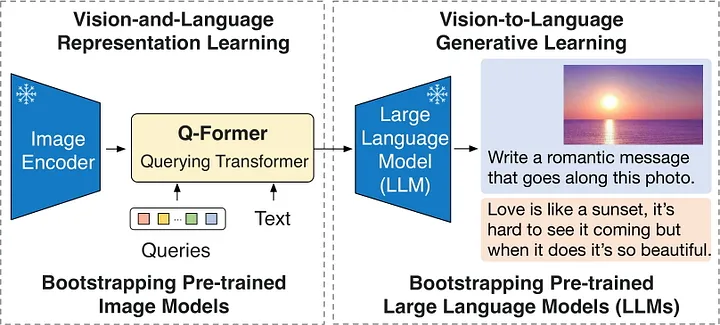

BLIP-2 cierra la brecha de modalidad entre los modelos de visión y lenguaje agregando un lightweight transformer (**Q-Former**) entre un **encoer** de imágenes preentrenado y un **LLM** estatico. 

**Q-Former** es la única parte entrenable de BLIP-2

Este **Q-Former** tiene dos submódulos que comparten las mismas capas de `self-attention`:

- un image tranformer que interactúa con el encoder para la extracción de características visuales
- un text transformer que puede funcionar como `encoder` y `decoder` de texto

**Q-Former** está preentrenado en dos etapas. 

1. En la primera etapa, el encoder de imágenes se congela y Q-Former se entrena con tres tipos de pérdidas:
- **Image-text contrastive loss:** se calcula la similitud por pares entre cada salida de consulta y el token CLS de la salida de texto, y se elige el más alto. query embeddings y el texto no se "ven" entre sí.
- **Generación de texto basada en imágenes:** las consultas pueden atenderse entre sí pero no a los tokens de texto, y el texto tiene una máscara causal y puede atender a todas las consultas.
- **Image-text matching loss:** las consultas y el texto pueden ver otros, y se obtiene un logit para indicar si el texto coincide con la imagen o no..

2. En la segunda etapa de preentrenamiento, las query embeddings ahora tienen la información visual relevante para el texto a medida que pasa por un cuello de botella de información. Estas incorporaciones ahora se utilizan como prefijo visual de la entrada al LLM. Esta fase de preentrenamiento implica efectivamente una tarea de generación de texto de imagen basada en la pérdida causal de LM.

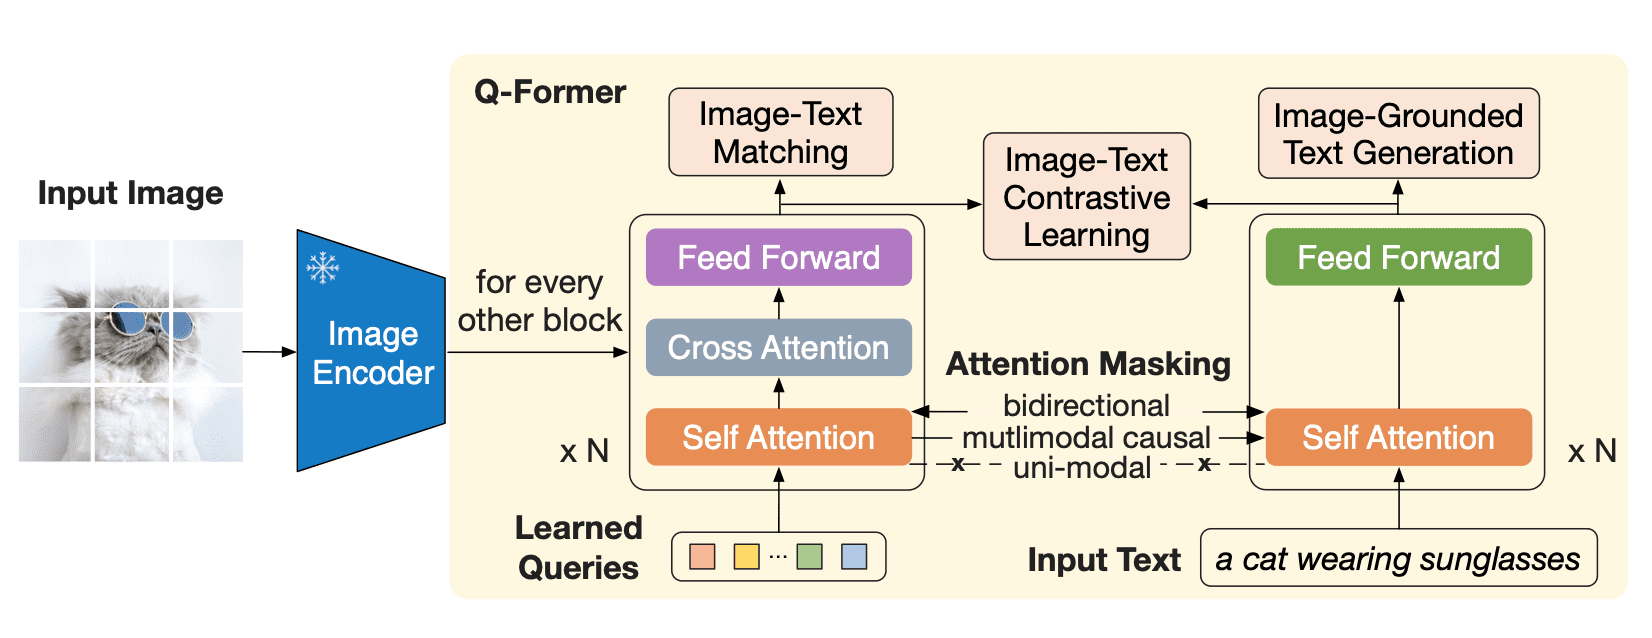

# 1. Cargar Imagen

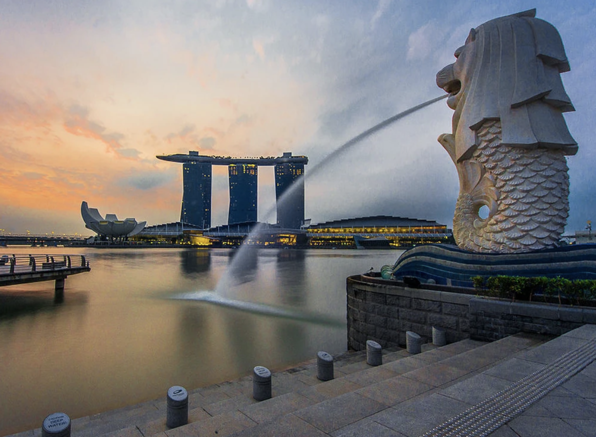

In [12]:
import requests
from PIL import Image

url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')   
display(image.resize((596, 437)))

# 2. Modelo y procesador

In [3]:
from transformers import BitsAndBytesConfig

q_config= BitsAndBytesConfig(
    load_in_8bit = True
)

In [8]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# there are several ways to load the model:
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
#model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", quantization_config=q_config) # load in int8
     

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [10]:
!nvidia-smi

Sun Jun 23 14:21:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0              32W / 250W |   4212MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 3. Captioning de imagenes

Si no se povee ningun prompt el modelo por default comienza generar texto desde el  BOS (beginning-of-sequence) token generando un caption para la imagen



In [14]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


singapore merlion - merlion fountain


# 4. Prompting image captioning

si provees un prompt el modelo continuara con base en eso

In [15]:
import warnings
warnings.filterwarnings("ignore")
prompt = "this is a picture of"
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a statue in singapore


In [17]:
prompt = "esto es una figura de "
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


izquierda en la marina


In [18]:
prompt = "the weather looks"
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


great for a walk in the park


# 5. VQA (Visual Quation answering)

In [19]:
prompt = "Question: which city is this? Answer:"
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


singapore


# 6. Interfaz de chat

Podemos crear una interfaz similar a ChatGPT simplemente concatenando cada respuesta generada a la conversación. Le indicamos al modelo un texto (como "¿qué ciudad es esta?"), el modelo genera una respuesta "Singapur"), que simplemente concatenamos con la conversación. Luego hacemos una pregunta de seguimiento ("¿por qué?") que también simplemente concatenamos y alimentamos al modelo.

Esto significa que el contexto no puede ser demasiado largo: modelos como OPT y T5 (los modelos de lenguaje que se utilizan en BLIP-2) tienen una longitud de contexto de 512 tokens.

In [20]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [21]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


merlion is a mythical creature that is said


# 7. Ejemplo alterno

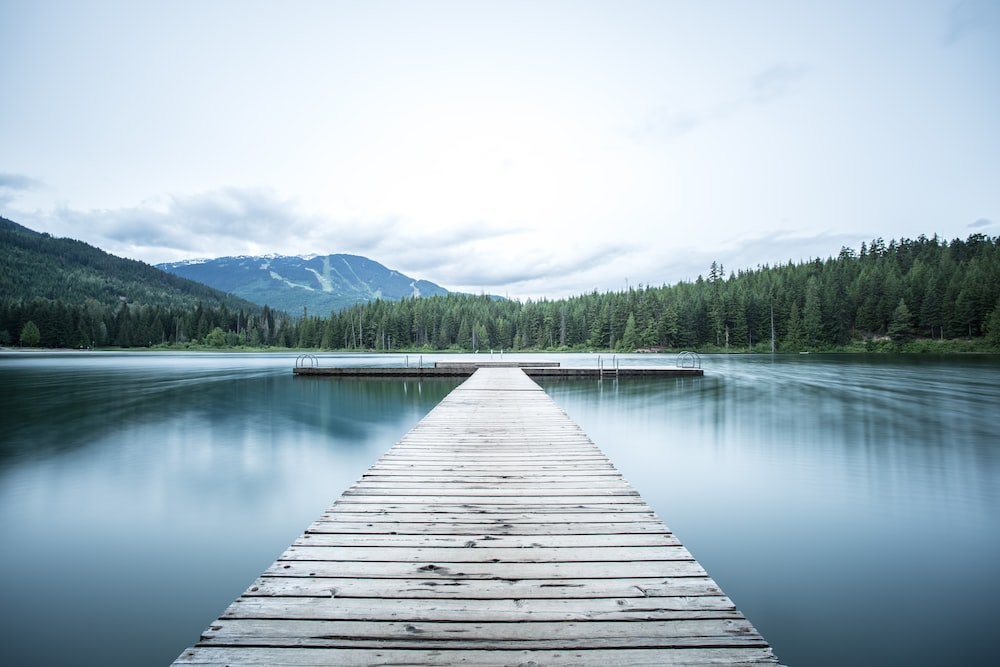

In [22]:
image1 = Image.open(requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True).raw)
display(image1)

In [23]:
inputs = processor(image1, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a wooden dock stretches out into a lake


In [24]:
prompt = "in this figure the most prominent feature is"
inputs = processor(image1, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text) # cool entiende el muelle como lo mas relevante!

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the dock, which is the most prominent feature of the image


In [25]:
prompt = "Question: in which country this could be? Answer:"
inputs = processor(image1, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


in canada


In [26]:
context = [
    ("in this figure the most prominent feature is", "the dock, which is the most prominent feature of the image"),
    #("why?", "it has a statue of a merlion"),
]
question = "why?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

#print(prompt)
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


because the dock is the most prominent feature of the image.


In [27]:
context = [
    ("in this figure the most prominent feature is", "the dock, which is the most prominent feature of the image"),
    ("why?", "because the dock is the most prominent feature of the image."),
]
question = "anything else?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

#print(prompt)
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=51)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=51) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


no
